# Úvod do strojového učení


### Úkol 0: 

Co si představujete pod pojmem strojové učení? 


![ilustracni_obr](static/ml.png)

### Ilustrační příklad na úvod - *imaginární krajina*

Dnešní hodina je trochu jiná, nebudeme se tolik zaměřovat na programování, to není při aplikaci strojového učení zas až tolik potřeba. Důležitejší je vědět, co chceme dělat a proč. Proto je naším cílem donutit vás přemýšlet. 

Půjdeme na to proto od lesa a začneme příkladem. 

Představte si, že jste si najali zeměměřiče a vyslali ho do neznámé krajiny. Zadali jste mu souřadnice několika bodů (žijeme ve teď v zjednodušeném prostoru, souřadnice je tedy pouze jedno číslo) a on pro vás naměřil zeměpisnou výšku v těchto bodech.   

Naměřené body máte zobrazeny na obrázku, který jste obdrželi na hodině vytištěný od kouče. Studujete-li doma, můžete si jej vytisknout ([PDF](static/krajina_public.pdf)).

*Kód níže nás nebude zajímat, slouží jen vygenerování obrázku "krajinky" (pro milovníky matematiky funkce).* 


In [28]:
%matplotlib inline

In [29]:
# importujeme knihovny jako obvykle
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn import preprocessing

plt.rcParams["figure.figsize"] = (20, 10)

# knihovna Scikitlearn občas produkuje warningy, které nás 
# nemusí znepokojovat 
# potlačíme jejich výpis 
import warnings
warnings.filterwarnings('ignore')

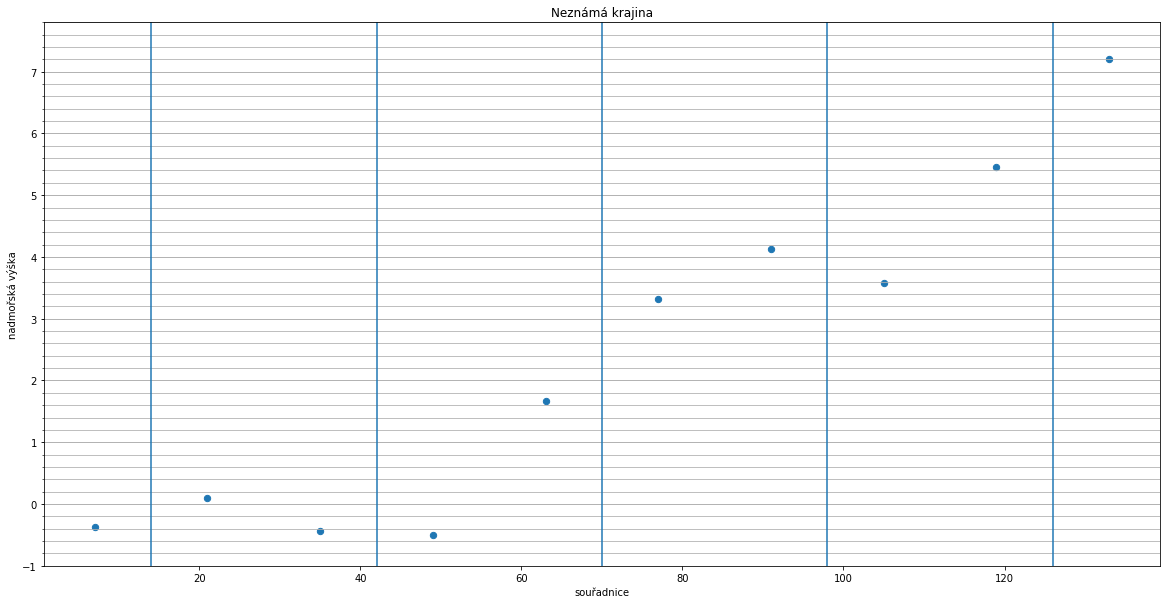

In [30]:
# kód v této buňce nám slouží k vygenerování krajiny a její zobrazování
# nečti jej, není v této hodině potřeba mu rozumět
# TODO: stejne kod prepsat a okomentovat 

ticks_per_1 = 5

TAJNE = 2.22

TRAIN_START = 7
TRAIN_STEP = 14 

TEST_START = 1+13
TEST_STEP  = 14*2

lim = 140
def fn(x):
    x /= 10
    return TAJNE*TAJNE + math.sin(x) + math.cos(TAJNE*x) + 0.2/TAJNE * x**2 - 0.1**TAJNE * x**(5-TAJNE) -6

df_landscape = pd.DataFrame(index=range(0, lim))
df_landscape["y"] = pd.Series(df_landscape.index).apply(fn)

df_landscape["y_sample"] = df_landscape["y"].loc[TRAIN_START::TRAIN_STEP]
df_landscape["y_test"] = df_landscape["y"].loc[TEST_START::TEST_STEP]

df_landscape["x_sample"] = df_landscape.index
df_landscape.loc[df_landscape["y_sample"].isnull(), "x_sample"] = None
df_landscape["x_test"] = df_landscape.index
df_landscape.loc[df_landscape["y_test"].isnull(), "x_test"] = None

def nakresli_krajinku(df, predicted=None, plot_gold=True):
    
    ax = df.plot(x="x_sample", y="y_sample", s=40, kind="scatter")
    margin = 10 # nemusi se pak resit rozsah obrazku
    if plot_gold:
        ax = df["y"].loc[margin:len(df)-margin].plot()
    if predicted:
        ax = df[predicted].loc[margin:len(df)-margin].plot()
    for tst_val in df["x_test"]:
        ax.axvline(tst_val)
        if predicted and not tst_val != tst_val:
            ax.plot(
                [tst_val, tst_val],
                [df.loc[tst_val, "y"], df.loc[tst_val, predicted]],
                marker = '_', color="red", linestyle="-", linewidth=3
            )
 

    y_bottom, y_top = ax.get_ylim()
    ax.set_yticks([x/ticks_per_1 for x in range(int(y_bottom-1)*ticks_per_1, int(y_top+1)*ticks_per_1)], minor=True)
    ax.set_xlabel("souřadnice")
    ax.set_ylabel("nadmořská výška")
    ax.set_title("Neznámá krajina")
    ax.grid(True, which='both', axis='y')
    return ax

nakresli_krajinku(df_landscape, plot_gold=False);


Po naměření těchto bodů se zeměměřič rozhodl státi datovým analytikem,
přihlásil se na kurz od PyLadies a s měřením definivně skončil. 
Nás by ale zajímalo, jak by asi tak mohla celá krajina vypadat.

### Úkol 1:
Vezměte si tužku a zkuste si na výše uvedeném obrázku nakreslit 
krajinu tak, jak si ji dle daných měření představujete. (Nejde nám o interpolaci! Není nutné, aby vaše *čára* vedla přímo skrz dané body. Uvědomte si, že měření mohou být zatížena chybou).

**Otázky:** 
+ Jsi si svým odhadem jistá? Existuje více možností, jak by mohla krajina vypadat?
+ Jak bys změřila (vyčíslila) kvalitu své schopnosti odhadovat neznámou krajinu?  
+ Podívej se na krajinku své sousedky. Zamysli se nad tím, jak by se dalo určit, která z vás krajinku vystihla lépe.



### Metrika

Z předchozího úkolu plyne, že existuje hodně možností, jak by mohla krajina vypadat. Také že potřebujeme nějakou míru, která nám umožní kvantifikovat kvalitu řešení. K tomu slouží tzv. **metriky**. 

Jak už z názvu vyplývá, metrika nám umožňuje něco měřit.

My potřebujeme měřit chybu něčeho. Na první pohled je to snadný úkol. Ale popravdě až zas tak ne.

Je lepší, když pro požadované hodnoty `[10, 30, 20]` dodáme výsledek `[12, 32, 22]`, nebo bude lepší výsledek `[15, 30, 20]`? A my to navíc potřebujeme zapsat matematicky, aby to i ten počítač chápal... 


## Odtajnění
Než se to pokusíme pro počítač zformulovat, podíváme se, jak neznámá krajina vypadá. (Pokud právě sedíš na kurzu, nezapomeň opravit hodnotu proměnné TAJNE dle instrukce kouče, abys dostala obrázek odpovídající tomu, který máš vytištěný.)

*Neznámou krajinu vidíme jen díky tomu, že se jedná o cvičnou úlohu. V praxi bychom jin nikdy celou k dispozici neměli.* 

Teď, když vidíš opravdovou podobu krajinky, tak bys ji určitě kreslila jinak. I proto jsme vám to `TAJNE` číslo tajili. Kdybyste viděly, jak má krajinka vypadat dopředu, tak by ono vyhodnocení nemohlo být nikdy férové.



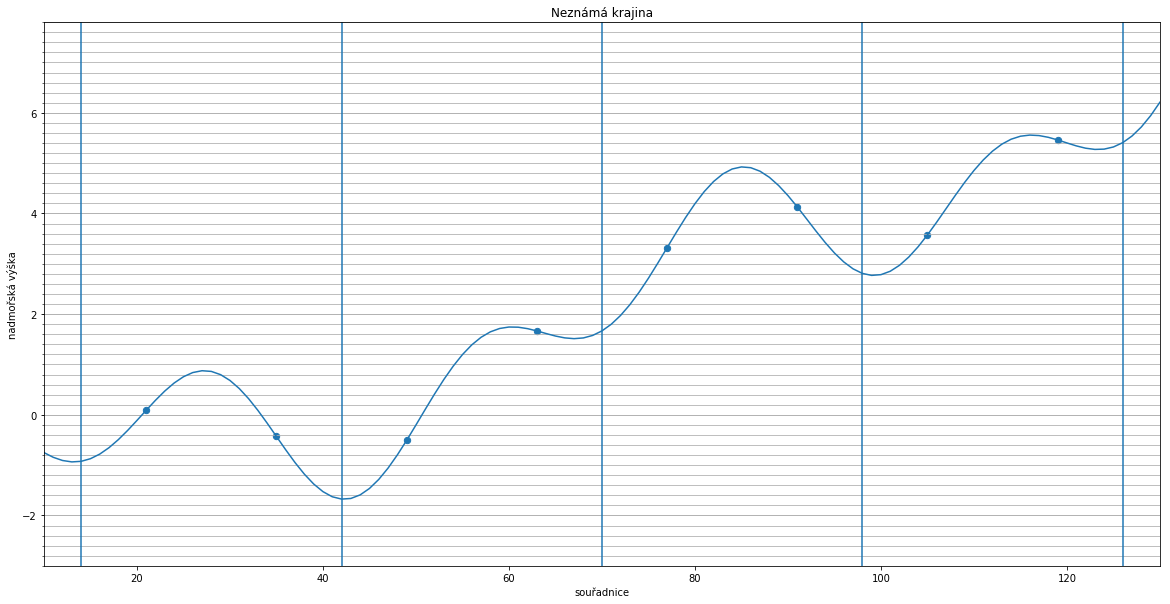

In [31]:
nakresli_krajinku(df_landscape);

### Úkol 2:

Pomocí mřížky na obrázku odečti hodnoty nadmořské výšky ze své krajinky v bodech vyznačených modrou čarou a doplň do tabulky v následujícím kódu.

In [32]:
__ = None  # pouze proto, aby kód byl syntakticky správně
df_landscape["můj_odhad"] = pd.Series()
df_landscape["můj_odhad"].loc[TEST_START::TEST_STEP]= [ __, __, __, __, __] # doplň čísla 


Dobrá zpráva je, že výšku krajinky v těchto bodech přeci jen známe (předvídavě jsme tyto body nechali stranou). Hodnoty najdeš ve sloupečku `"x_test"` a `"y_test"` DataFramu `d`. 

Napiš funkci (**metriku**), která vyhodnotí, jak moc byl odhad tvé krajinky úspěšný.

+ Použij svoji metriku a urči, zda je z tvého pohledu úspěšný tvůj nebo sousedčin odhad.
+ Zatím víš jen, jestli jsi lepší než sousedka nebo ne. Ale jak určit, zda schopnost člověka odhadnout krajinku za něco stojí nebo ne?


#### Jak zapíšeme metriku?

Je to funkce, která vezme **správné** a **odhadnuté** hodnoty a vyrobí z nich nějakou číselnou reprezentaci **správnosti**.




In [33]:
def moje_metrika(y_true, y_pred):
    """ Funkce vyhodnotí úspěšnost predikce krajinky (funkce). 
    y_true jsou skutečné hodnoty, y_pred jsou predikované hodnoty.
    """
    ...
    
# TODO dopsat pomocnou funkci, aby mohli uvazovat ze y_true a y_pred
# jsou jen floaty 

moje_metrika(df_landscape["y_test"], df_landscape["můj_odhad"])

Zkusíme vzít hloupý odhad a podívat se, jestli je naše řešení lepší. 


In [34]:
mean_value = df_landscape["y_sample"].mean()
df_landscape["jednoduchý_odhad"] = pd.Series()
df_landscape["jednoduchý_odhad"].loc[TEST_START::TEST_STEP] = mean_value

moje_metrika(df_landscape["y_test"], df_landscape["jednoduchý_odhad"])

##  Konečně ke strojovému učení ...

Teď přichází jediná dobrá zpráva z dnešní lekce. **Strojové učení** (machine learning) nabízí metody (algoritmy), které dokáží méně či více úspěšně provést obdobný odhad (nejen) krajinky za tebe. 

Představ si tuto metodu jako *černou krabičku*, která má nějaké vstupy a nějaké výstupy. Takové krabičce se říká **model**. Do vstupů můžeš sypat čísla (seznamy čísel) a krabička na výstupu bude chrlit odpovědi (také čísla, třeba nadmořskou výšku).
V případě krajinky zadáš souřadnici (třeba seznam souřadnic $[x_1, x_2]$) a krabička ti prozradí, jaká je v daném bodě nadmořská výška. Souřadnice, které jdou na vstup *krabičky* (modelu), označujeme jako příznaky (**features**) nebo vstupní proměnné, regressory. Na výstupu je nějaká odezva (závislá proměnná). 

![černá skříňka](static/blackbox.png)



Samozřejmě krabička nemůže sama od sebe vědět, zda se ptáš na krajinu v Krkonoších nebo v Polabí. Proto je třeba krabičku nejprve **naučit** (natrénovat, nafitovat) na úkol, který po ní budeme požadovat. V podstatě do krabičky v nějaké formě uložíme to, co zatím o krajince víme.
Krabička to zvládne sama, my jí jen musíme poskynout dostatečné množství příkladů (trénovacích vzorů) souřadnic a odpovídajícíh výšek. Takovému učení, kde jsou k dispozici správné odpovědi, se říká **supervised learning**, česky **učení s učitelem**.

Pojďme si několik krabiček vyzkoušet. Využijeme knihovnu [scikit-learn](https://scikit-learn.org/). Knihovna poskytuje nejen velké množství různých chytrých krabiček, ale také výbornou [dokumentaci](https://scikit-learn.org/stable/user_guide.html), kterou doporučujeme k následnému samostudiu a experimentování. V příští hodině projdeme nejdůležitější funkce, které budeš potřebovat (dnes nemusíš kód příliš zkoumat).


In [35]:
# Importujeme knihovnu scikit-learn 
import sklearn

Níže je funkce `vyhodnost_krabicku`, která černou krabičku natrénuje na naši krajinku a ohodnotí testovací body. 
Druhá funkce `zobraz_vysledek` nám všechno vykreslí a vypíše hodnoty a chyby v jednotlivých bodech.

Kód sám o sobě není v tuto chvíli důležitý, dnes nás nezajímá syntaxe, stačí když se budeš dívat na výsledné obrázky.

In [36]:
def vyhodnot_krabicku(df_, CernaKrabicka, **kwargs):
    df = df_.copy()
    X = df[["x_sample"]].dropna()
    y = df["y_sample"].dropna()
    X /= 140 
    cerna_krabicka = CernaKrabicka(**kwargs).fit(X, y)
    return cerna_krabicka.predict(pd.DataFrame(df.index)/140)
    
def zobraz_vysledek(df_, sloupec):
    df = df_.copy()
    ax = nakresli_krajinku(df, predicted=sloupec)
    seznam_chyb = []
    for tst_val in df["x_test"].dropna():
        seznam_chyb.append([df.loc[tst_val, "y"], df.loc[tst_val, sloupec]])
    for spravne, predpoved in seznam_chyb:
        print(f"Správně bylo {spravne:+2.1f}, předpovězeno {predpoved:+2.1f}. Absolutní chyba je {predpoved-spravne:+2.1f}.")
    return ax


    

# První černá krabička

In [37]:
from sklearn.linear_model import LinearRegression as CernaKrabicka

Správně bylo -0.9, předpovězeno -1.0. Absolutní chyba je -0.1.
Správně bylo -1.7, předpovězeno +0.7. Absolutní chyba je +2.4.
Správně bylo +1.7, předpovězeno +2.4. Absolutní chyba je +0.7.
Správně bylo +2.8, předpovězeno +4.1. Absolutní chyba je +1.3.
Správně bylo +5.4, předpovězeno +5.8. Absolutní chyba je +0.4.


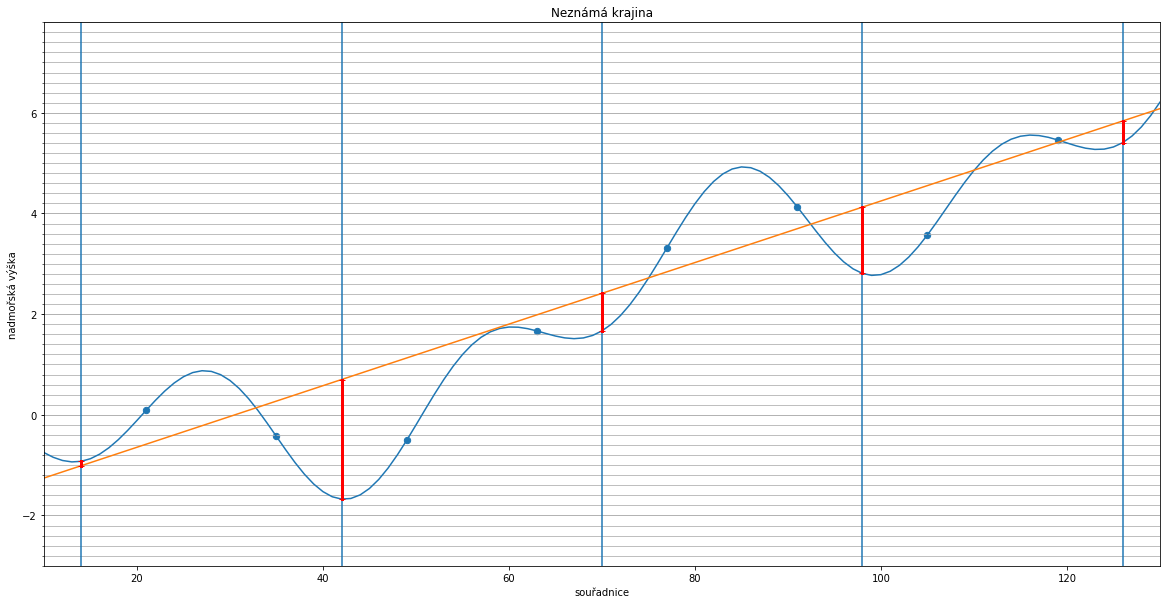

In [38]:
i = 1
df_landscape[f"predikce_krabickou_{i}"] = vyhodnot_krabicku(df_landscape, CernaKrabicka)
zobraz_vysledek(df_landscape, f"predikce_krabickou_{i}");

### Úkol 3:

Ohodnoť kvalitu odhadu černé krabičky pomocí metriky, kterou jsi navrhla v úkolu 2. Je tvůj odhad lepší? 
(stačí nám zavolat funkci `moje_metrika` na příslušné sloupečky dataframu)

In [39]:
#  kód k úkolu 3 

# Další černé krabičky

Zkusme ještě další krabičky. Prohlédni si pozorně obrázky. Pokud zbývá čas, můžeš si vyzkoušet, zda hodnocení výsledků tvojí metrikou je podobné jako visuální dojem.

Správně bylo -0.9, předpovězeno -0.2. Absolutní chyba je +0.7.
Správně bylo -1.7, předpovězeno -0.3. Absolutní chyba je +1.4.
Správně bylo +1.7, předpovězeno +2.1. Absolutní chyba je +0.4.
Správně bylo +2.8, předpovězeno +4.0. Absolutní chyba je +1.2.
Správně bylo +5.4, předpovězeno +6.0. Absolutní chyba je +0.6.


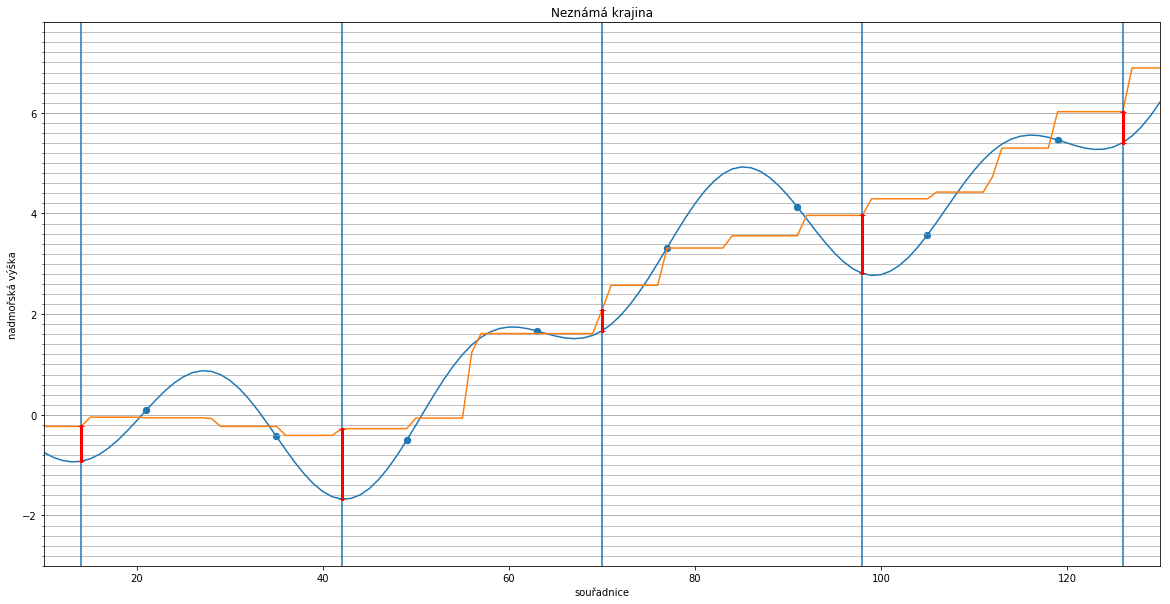

In [41]:
from sklearn.ensemble import RandomForestRegressor as CernaKrabicka

i = 2
df_landscape[f"predikce_krabickou_{i}"] = vyhodnot_krabicku(df_landscape, CernaKrabicka)
zobraz_vysledek(df_landscape, f"predikce_krabickou_{i}");

Správně bylo -0.9, předpovězeno +0.7. Absolutní chyba je +1.6.
Správně bylo -1.7, předpovězeno +1.4. Absolutní chyba je +3.0.
Správně bylo +1.7, předpovězeno +2.2. Absolutní chyba je +0.5.
Správně bylo +2.8, předpovězeno +3.1. Absolutní chyba je +0.3.
Správně bylo +5.4, předpovězeno +3.7. Absolutní chyba je -1.7.


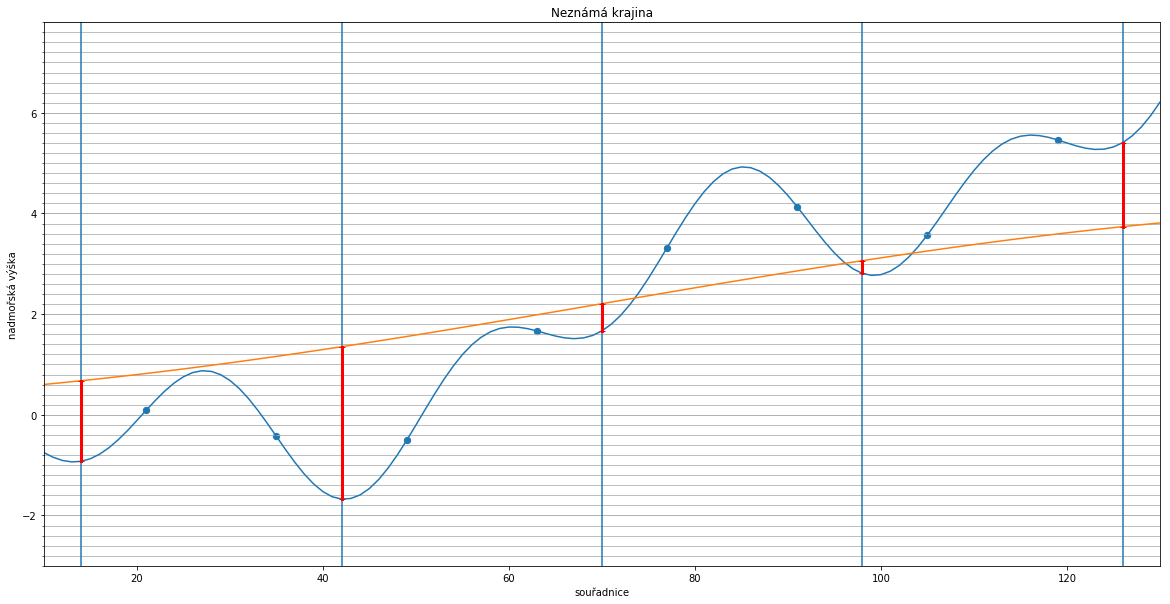

In [43]:
from sklearn.svm import SVR as CernaKrabicka

i=3
df_landscape[f"predikce_krabickou_{i}"] = vyhodnot_krabicku(df_landscape, CernaKrabicka)

zobraz_vysledek(df_landscape, f"predikce_krabickou_{i}");

Správně bylo -0.9, předpovězeno -0.6. Absolutní chyba je +0.3.
Správně bylo -1.7, předpovězeno +0.1. Absolutní chyba je +1.8.
Správně bylo +1.7, předpovězeno +2.3. Absolutní chyba je +0.7.
Správně bylo +2.8, předpovězeno +4.2. Absolutní chyba je +1.3.
Správně bylo +5.4, předpovězeno +6.2. Absolutní chyba je +0.8.


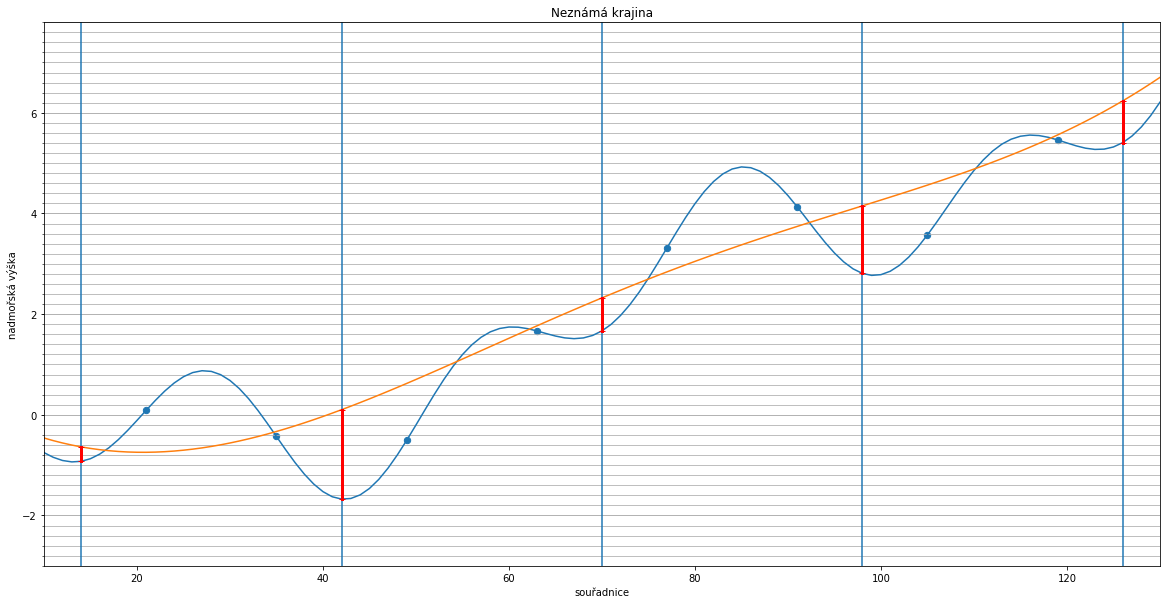

In [45]:
from sklearn.svm import SVR as CernaKrabicka

i=4
df_landscape[f"predikce_krabickou_{i}"] = vyhodnot_krabicku(df_landscape, CernaKrabicka, C=10000)
zobraz_vysledek(df_landscape, f"predikce_krabickou_{i}");

Správně bylo -0.9, předpovězeno +2.0. Absolutní chyba je +2.9.
Správně bylo -1.7, předpovězeno +2.0. Absolutní chyba je +3.6.
Správně bylo +1.7, předpovězeno +2.4. Absolutní chyba je +0.8.
Správně bylo +2.8, předpovězeno +2.6. Absolutní chyba je -0.2.
Správně bylo +5.4, předpovězeno +3.0. Absolutní chyba je -2.4.


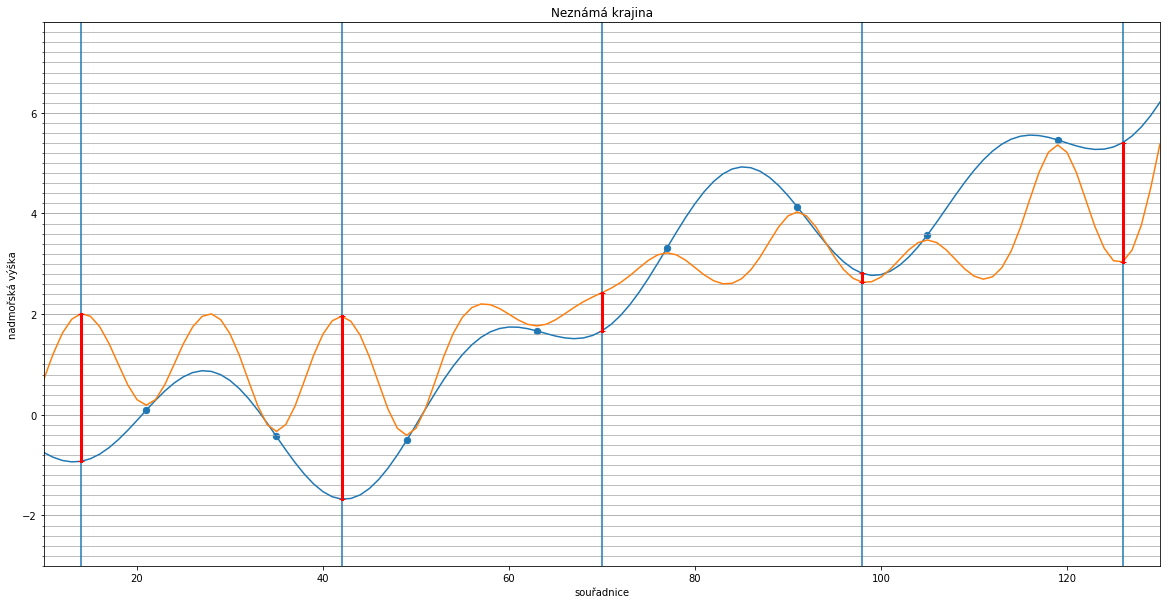

In [46]:
from sklearn.svm import SVR as CernaKrabicka

i = 5
df_landscape[f"predikce_krabickou_{i}"] = vyhodnot_krabicku(df_landscape, CernaKrabicka, gamma=1000, C=10)
zobraz_vysledek(df_landscape, f"predikce_krabickou_{i}");

Poslední příklad ilustruje užitečnost **testovací množiny**. Vzorkům, na kterých model (černou krabičku) učíme, obvykle 
říkáme **trénovací množina**. Vzorkům, které si necháme stranou, **testovací množina**. 

## Úkol 4:

 - Který z modelů krajiny se ti nejvíce líbí? 
 - Jaké jsou asi výhody a nevýhody jednotlivých modelů?
 - Všimni si posledního obrázku. Jak ohodnotí tvá metrika výsledek, použiješ-li hodnoty v bodech trénovací množiny? Jak dopadne na testovací množině?

Situaci, kdy model dává správnou odezvu pro data z **trénovací množiny**, ale špatně odhaduje vzory, které během učení nebyly k dispozici, říkáme **přeučení** (**overfitting**). Podobně jako když se student naučí vzorové odpovědi zpaměti, ale nepochopí zákonitosti (neumí **generalizovat**). 
Opačná situace se označuje jako **underfitting**, což je např. použití přímky (lineární regrese) k modelování zvlněné krajiny (nelineární funkce). 

![overfit_underfit_example](static/overfit.png)




 ## Zpět ke dvoum dimenzím

In [ ]:
# TODO tady jsme chteli dvoudimenzionalni rychly priklad
# klidne bych to vypustila

Zobecníme si příklad na krajinu, kde se souřadnice zadávají zeměpisnou šířkou a dékou.

TODO: Roman? kratší příklad

## Hyper-parametry 

U příkladů výše jsme funkci `vyhodnot krabicku` předávali data a krabičku (model). Několikrát jsme si ale trochu pomohli a předali jsme tiše ještě nějaké další parametry.  Krabička totiž často umožňuje uživateli, aby si ji nakonfiguroval. V terminologii krabiček si můžeme představit, že krabička má na sobě různé páčky, kterými se dá seřídit. Těmito páčkami se nastavují tzv. **hyper-parametry** modelu. Všechny modely, které najdeš v knihovně Scikit-learn, mají nějaké defaultní nastavení a půjdou použít i bez toho, aby ses nastavením těchto **hyper-parametrů** zabývala.  
V případě, že model nedává uspokojivý výsledek, můžeš zkusit tyto parametry upravit, např. vyzkoušet několik různých nastavení a porovnat hodnotu metriky na testovací množině.  
K problému hledání vhodných **hyper-parametrů** se vrátíme na začátku příští hodiny. 

Pokud budeš pokračovat samostudiem, výběr vhodného modelu a nastavení jeho hyperparametrů se skrývá pod klíčovým slovem **model selection**. Knihovna Scikit-learn poskytuje nástroje, jak si toto hledání automatizovat. *(TODO: Pozn. tohle bych ale asi dala do další hodiny, až se bude řešit ta evaluační množina).*